# Simple Simulation of Alanine Dipeptide
Authors: Benjamin D. Madej & Ross Walker<br>
Original Link: https://ambermd.org/tutorials/basic/tutorial0/index.php<br>
Adapted by: Jeremy Leung<br>
Email:&nbsp;&nbsp; jml230@pitt.edu


## Setup

Welcome! This notebook is made with the assumption that you're working on `jupyter.crc.pitt.edu` and have setup your virtual environments using https://github.com/jeremyleung521/h2p-quickstart/tree/drug-design2025. If not, following the steps in "[Setting up the virtual environment](#Setting-up-the-virtual-environment)" section.

To start, make sure it says `drug-design2025` on the top right hand corner! If it doesn't, click on `Python 3 (ipykernel)` (Or whatever it currently is) and select `drug-design2025` from the drop down menu as your preferred kernel. Click Select.

![image](./img/Notebook-kernel.png)

### Setting up the virtual environment

1. Start a terminal (Should be an option in the "Launcher" tab)
2. run `cd ~`
3. run `git clone https://github.com/jeremyleung521/h2p-quickstart -b drug-design2025`
4. run `cd h2p-quickstart`
5. run `bash run_bash.sh` then wait. It might take a short while.
6. run `bash activate_env.sh`


## Learning Objectives

- navigate the command line interface through terminal and `tleap` to prepare topology and coordinate files
- understand the basics of force fields and be able to load the FF19SB force field to be able to work with the alanine dipeptide
- set up an explicit water simulation in tleap
- perform basic equilibration
- perform production run simulations at a given temperature
- Visualize the results of production MD in <code>nglview</code>
- Use <code>matplotlib</code> to plot MD thermodynamic data such as temperature, density, and energy
- Use <code>mdtraj</code> to calculate the root mean square displacement (RMSD) of the trajectory relative to the initial structure



## System Requirements
- AmberTools24 is necessary to run this simulation.
    - Note that it is already installed as a module on H2P
- numpy, matplotlib, ipympyl, mdtraj, and nglview are used in this jupyter notebook. 
    - nglview, matplotlib, ipympl, and numpy are optional for visualization purposes.
    - These are already installed as part of the virtual environment.

## Introduction

This tutorial is designed to provide an introduction to molecular dynamics simulations with Amber. It is designed for AMBER 24 and for new users who want to learn about how to run molecular dynamics simulations with Amber. This notebook is designed with the assumption that you are working within a virtual environment on the H2P Cluster at Pitt.

AMBER stands for Assisted Model Building and Energy Refinement. It refers not only to the molecular dynamics programs, but also a set of force fields that describe the potential energy function and parameters of the interactions of biomolecules.

In order to run a Molecular Dynamics simulation in Amber, each molecule's interactions are described by a molecular force field. The force field has specific parameters defined for each molecule.

<code>sander</code> is the basic MD engine of Amber. <code>pmemd</code> is the high performance implementation of the MD engine that contains a subset of features of <code>sander</code>. <code>pmemd</code> can also be run with acceleration from graphics processing units (GPU) through <code>pmemd.cuda</code> or the MPI parallel version <code>pmemd.mpi</code>.

In order to run an MD simulation with sander or pmemd, three key files are needed:

    parm7 - The file that describes the parameter and topology of the molecules in the system
    rst7 - The file that describes the initial molecular coordinates of the system
    mdin - The file that describes the settings for the Amber MD engine


## 1. Building the Simulation System (Alanine Dipeptide)

We will now begin to build the solvated alanine dipeptide from scratch using a program called `tleap`.

The first line of the following cell is a jupyter notebook "magic command" to export the next lines of the cell into a file called <code>build_diala.in</code>. The rest are commands telling <code>tleap</code> to generate a solvated alanine dipeptide. Expand the next section if you would like to know what each line means!

We can build an alanine dipeptide as an alanine amino acid capped with an acetyl group on the N-terminus and N-methylamide on the C-terminus. After we loaded the force field ff19SB, tLEaP now has these "units" available to build into a molecule. The sequence command will create a new unit from the available units and connect them together.

In [1]:
%%writefile tleap.in  
source leaprc.protein.ff19SB  
source leaprc.water.opc
diala = sequence { ACE ALA NME } 
solvateoct diala OPCBOX 10.0
saveamberparm diala diala.parm7 diala.rst7
quit

Overwriting build_diala.in


### Explaining each step

#### Load a protein force field

A force field is the Hamiltonian (potential energy function) and the related parameters that describe the intra- and intermolecular interactions between the molecules in the system. In MD, the Hamiltonian is integrated to describe the forces and velocities of the molecules (See [Allen and Tildesley](https://global.oup.com/academic/product/computer-simulation-of-liquids-9780198803201?cc=us&lang=en&#)).

The basic form of the Amber force field is:

![image](./img/Amber_Hamiltonian.png)
In order to run a molecular dynamics simulation, we need to load a force field to describe the potential energy of alanine dipeptide. We will use the AMBER force field FF19SB1for proteins. To learn more about force fields, please look through section 3.1.1 on page 34 of the [Amber 2024 Manual](https://ambermd.org/doc12/Amber24.pdf#page=34). 

- The first two `source` lines load in force field parameters(for the Amber ff19SB force field and OPC 3-point water model parameters, respectively).
```
source leaprc.protein.ff19SB  
source leaprc.water.opc
```

#### Build alanine dipeptide


We can build an alanine dipeptide as an alanine amino acid capped with an acetyl group on the N-terminus and N-methylamide on the C-terminus. After we loaded the force field ff19SB, tLEaP now has these "units" available to build into a molecule. The sequence command will create a new unit from the available units and connect them together.

- We will use sequence to create a new unit called diala out of the ACE, ALA, and NME units.  ACE, ALA and NME stands for {acetyl group, alanine, N-methyl amide}, respectively. Note that when you connect the acetyl group with the N-methyl amide you get an alanine residue!

```
diala = sequence { ACE ALA NME }
```

#### Solvate alanine dipeptide

The next step to prepare this alanine dipeptide system is to solvate the molecule with explicit water molecules. There are many water models available for MD simulations. In this simulation we will add OPC water molecules2 to the system. The ff19SB force field gives the best performance with the OPC water model and is strongly recommended (see page 36 of the Amber 2020 Manual). To learn more about the OPC water model, please look at section 3.5.1 on pages 53 and 54 of the Amber 2020 Manual.

In this type of simulation, the system has periodic boundary conditions, meaning that molecules that exit one side of the system will wrap to the other side of the system. It is important that the periodic box is large enough, i.e. there is enough water surrounding alanine dipeptide, so that the alanine dipeptide molecule does not interact with its periodic images.

- Solvating the alanine dipeptide into a cubic water box with at least 10 Å clearance to the edge of the box. OPCBOX specifies the type of specifies the type of water box to solvate the solute (diala). The 10.0 indicates that the molecule should have a buffer of at least 10 Angstroms between alanine dipeptide and the periodic box wall.   
```
solvateoct diala OPCBOX  10.0
```

#### Save the Amber parm7 and rst7 input files

Now we will save the parm7 and rst7 files to the current working directory. The parm7 topology file defines which atoms are bonded to each other and the rst7 coordinate file defines where each atom is located on a 3-dimensional coordinate plane. The unit diala now contains the alanine dipeptide molecule, water molecules, and the periodic box information necessary for simulation. The parameters will be assigned from the ff19SB force field. 


- Export the peptide into a paramter file `parm7` and a coordinate file `rst7`.
```
saveamberparm diala parm7 rst7
```

#### Quit tLEaP

Exit from the `tleap` program at the end
```
quit
```

### Running `tleap`

Run `tleap` with the following line. The first half loads in the Amber24 module from the H2P cluster. The second half (`tleap ...`) is the actually command we will run.

If you see the following lines at the end of the output, you've successfully built the system!
```
Exiting LEaP: Errors = 0; Warnings = 0; Notes = 1.
```

In [9]:
!module load gcc/10.2.0 openmpi/4.1.1 amber/24 &&\
tleap -f build_diala.in 

         -gencode arch=compute_61,code=[compute_61,sm_61] 
         -gencode arch=compute_70,code=[compute_70,sm_70] 
         -gencode arch=compute_89,code=[compute_89,sm_89] 
If running on TEACH cluster:         -arch=sm_52 
         -gencode arch=compute_61,code=[compute_61,sm_61] 
         -gencode arch=compute_70,code=[compute_70,sm_70] 
         -gencode arch=compute_89,code=[compute_89,sm_89] 
If running on TEACH cluster:         -arch=sm_52 
-I: Adding /ihome/crc/install/amber/amber24/amber24/dat/leap/prep to search path.
-I: Adding /ihome/crc/install/amber/amber24/amber24/dat/leap/lib to search path.
-I: Adding /ihome/crc/install/amber/amber24/amber24/dat/leap/parm to search path.
-I: Adding /ihome/crc/install/amber/amber24/amber24/dat/leap/cmd to search path.
-f: Source build_diala.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./build_diala.in
----- Source: /ihome/crc/install/amber/amber24/amber24/dat/leap/cmd/leaprc.protein.ff19SB
----- Source of /ihome/crc/inst

## 2. Prepare Amber MD input files

The last components needed are the input files that define the program settings for each MD run. For this system, we will perform an energy minimization on the system, then slowly heat the system, and then do production MD at the desired temperature and pressure. `Sander` will be used for minimization and heating and `pmemd` will be used for the actual production run. To learn more about sander and pmemd, please refer to the Amber 2024 Manual.

1. Minimization
1. Heating with constant volume and temperature (NVT) for 20 ps from 0 K to 300 K
1. Production MD with constant pressure and temperature (NPT) at 300 K and 1 atm for 60 ps

We will save the trajectory and write to the output file every 2 ps. The Langevin thermostat will be used to control the temperature. The random number generator will be initialized with a random seed.

To control all these settings, we will write a simple input file in a text editor. Unix has many text editors available, but we will use the one built into Jupyter Lab.

The following cell will create the file. You may open (and edit) the file by double clicking it in the file browser to the left. Edit it to your liking (and press `Cmd/Ctrl+s` to save)


### Minimization input

In [6]:
%%writefile 01_Min.in  
Minimize
 &cntrl
  imin=1,
  ntx=1,
  irest=0,
  maxcyc=2000,
  ncyc=1000,
  ntpr=100,
  ntwx=0,
  cut=8.0,
 /

Overwriting 01_Min.in


The settings can be summarized as follows:
```
imin=1         Choose a minimization run
ntx=1          Read coordinates but not velocities from ASCII formatted rst7 coordinate file
irest=0        Do not restart simulation. (not applicable to minimization)
maxcyc=2000    Maximum minimization cycles
ncyc=1000      The steepest descent algorithm for the first 0-ncyc cycles, then switches the conjugate gradient algorithm for ncyc-maxcyc cycles
ntpr=100       Print to the Amber mdout output file every ntpr cycles
ntwx=0         No Amber mdcrd trajectory file written (not applicable to minimization)
cut=8.0        Nonbonded cutoff distance in Angstroms (for PME, limit of the direct space sum - do NOT reduce this below 8.0. Higher numbers give slightly better accuracy but at vastly increased computational cost.)
```

For more information on minimization, please take a look at the General minimization and dynamics parameters section on page 387 of the [Amber 2024 Manual]((https://ambermd.org/doc12/Amber24.pdf#page=387)).

### Heating input

In [5]:
%%writefile 02_Heat.in  
Heat
 &cntrl
  imin=0,
  ntx=1,
  irest=0,
  nstlim=10000,
  dt=0.002,
  ntf=2,
  ntc=2,
  tempi=0.0,
  temp0=300.0,
  ntpr=100,
  ntwx=100,
  cut=8.0,
  ntb=1,
  ntp=0,
  ntt=3,
  gamma_ln=2.0,
  nmropt=1,
  ig=-1,
 /
&wt type='TEMP0', istep1=0, istep2=9000, value1=0.0, value2=300.0 /
&wt type='TEMP0', istep1=9001, istep2=10000, value1=300.0, value2=300.0 /
&wt type='END' /

Writing 02_Heat.in


The settings can be summarized as follows:
```
imin=0          Choose a molecular dynamics (MD) run [no minimization]
nstlim=10000    Number of MD steps in run (nstlim * dt = run length in ps)
dt=0.002        Time step in picoseconds (ps). The time length of each MD step
ntf=2           Setting to not calculate force for SHAKE constrained bonds
ntc=2           Enable SHAKE to constrain all bonds involving hydrogen
tempi=0.0       Initial thermostat temperature in K (see NMROPT section)
temp0=300.0     Final thermostat temperature in K (see NMROPT section)
ntwx=1000       Write Amber trajectory file mdcrd every ntwx steps
ntb=1           Periodic boundaries for constant volume
ntp=0           No pressure control
ntt=3           Temperature control with Langevin thermostat
gamma_ln=2.0    Langevin thermostat collision frequency
nmropt=1        NMR restraints and weight changes read (see NMROPT section)
ig=-1           Randomize the seed for the pseudo-random number generator [always a good idea unless you are debugging a simulation problem]
```

For more information on heating, please take a look at the Temperature regulation subsection on page 393 of the [Amber 2024 Manual](https://ambermd.org/doc12/Amber24.pdf#page=393).   

The final three lines allow the thermostat to change its target temperature throughout the simulation. For the first 9000 steps, the temperature will increase from 0 K to 300 K. For steps 9001 to 10000, the temperature will remain at 300 K. 

### Production input

Warning:
By itself, this input file is not intended for general MD simulations.

NTPR and NTWX are set very low so that it is possible to analyze this short simulation. Using these settings for longer MD simulations will create very large output and trajectory files and will be slower than regular MD. For real production MD, you'll need to increase NTPR and NTWX.

The production time of this simulation will be 10 ns. Using a time step (dt) of 0.002 ps, a nstlim value of 5000000 will give us this simulation time.



In [7]:
%%writefile 03_Prod.in  
Production
 &cntrl
  imin=0,
  ntx=5,
  irest=1,
  nstlim=5000000,
  dt=0.002,
  ntf=2,
  ntc=2,
  temp0=300.0,
  ntpr=100,
  ntwx=100,
  cut=8.0,
  ntb=2,
  ntp=1,
  ntt=3,
  barostat=1,
  gamma_ln=2.0,
  ig=-1,
 /

Writing 03_Prod.in


The settings for production can be summarized as follows:
```
ntx=5           Read coordinates and velocities from unformatted rst7 coordinate file
irest=1         Restart previous MD run [This means velocities are expected in the rst7 file and will be used to provide initial atom velocities]
temp0=300.0     Thermostat temperature. Run at 300K
ntb=2           Use periodic boundary conditions with constant pressure
barostat=1      Use the Berendsen barostat for constant pressure simulation
```

For more information on pressure control, please take a look at the Pressure regulation subsection on page 395 of the [Amber 2024 Manual](https://ambermd.org/doc12/Amber24.pdf#page=395).

## 3. Run Amber MD Simulation

Now that we have all the ingredients: the parameter and topology file `parm7`, the coordinate file `rst7`, and the input files `01_Min.in`, `02_Heat.in`, `03_Prod.in`, we are ready to run the actual minimization, heating, and production MD.

To do this, we will use the program pmemd which is run from the command line. On the command line, we can specify several more options and choose which files are to be used for input.

### Run minimization

In [14]:
!module load gcc/10.2.0 openmpi/4.1.1 amber/24 &&\
sander -O -i 01_Min.in -o 01_Min.out -p diala.parm7 -c rst7 -r 01_Min.ncrst \
-inf 01_Min.mdinfo

         -gencode arch=compute_61,code=[compute_61,sm_61] 
         -gencode arch=compute_70,code=[compute_70,sm_70] 
         -gencode arch=compute_89,code=[compute_89,sm_89] 
If running on TEACH cluster:         -arch=sm_52 


`sander` uses a consistent syntax for each step of MD simulation. Here is a summary of the command line options of sander:
```
-O
	Overwrite the output files if they already exist
-i 01_Min.in
	Choose input file (default mdin)
-o 01_Min.out
	Write output file (default mdout)
-p parm7
	Choose parameter and topology file parm7
-c rst7
	Choose coordinate file rst7
-r 01_Min.ncrst
	Write output restart file with coordinates and velocities (default restrt)
-inf 01_Min.mdinfo
	Write MD info file with simulation status (default mdinfo)
```

To learn more about syntax when using sander, please look at Section 21.2 of the [Amber 2024 Manual](https://ambermd.org/doc12/Amber24.pdf#page=384).

`sander` should complete the minimization in a moderate amount of time (~ 30 seconds) depending on your computer specifications.

After `sander` completes, there should be an output file `01_Min.out`, a restart file `01_Min.ncrst`, and a MD info file `01_Min.mdinfo`. You will use the restart file `01_Min.ncrst` for the heating of the system.

#### Minimization output files

Sample output files are located in `sample_files`:
```
sample_files/01_Min.out
sample_files/01_min.ncrst
```

In the `01_Min.out` file, you will find the details of your minimization. You should be able to see the system energy ENERGY decrease throughout the minimization.

### Run heating MD

In [23]:
!module load gcc/10.2.0 openmpi/4.1.1 amber/24 &&\
sander -O -i 02_Heat.in -o 02_Heat.out -p ala.parm7 -c 01_Min.ncrst \
-r 02_Heat.ncrst -x 02_Heat.nc -inf 02_Heat.mdinfo

         -gencode arch=compute_61,code=[compute_61,sm_61] 
         -gencode arch=compute_70,code=[compute_70,sm_70] 
         -gencode arch=compute_89,code=[compute_89,sm_89] 
If running on TEACH cluster:         -arch=sm_52 

  Error opening unit    8: File "ala.parm7" is missing or unreadable                


Here is a summary of the command line options for `sander`:
```
-c 01_Min.ncrst
	Now for the input coordinates we choose the restart file from minimization
-x 02_Heat.nc
	Output trajectory file for MD simulation (default nc)
```
sander should complete the heating in a moderate amount of time (~ 2.5 mins) depending on your computer specifications. 

#### Heating output files

Sample output files are located in `sample_files`:
```
sample_files/01_Min.out
sample_files/01_min.ncrst
```



In the `02_Heat.out` file you will find the output from the heating MD. You should be able to see system information including timestep energies, and temperature. For example on the 1000 time step:

```
NSTEP =     1000   TIME(PS) =       2.000  TEMP(K) =    30.80  PRESS =     0.0
 Etot   =     -9636.4025  EKtot   =       130.0070  EPtot      =     -9766.4095
 BOND   =        0.5896   ANGLE   =         1.6788  DIHED      =         2.6834
 1-4 NB =         2.8404  1-4 EEL =        45.1563  VDWAALS    =      1584.9308
 EELEC  =     -11403.7559 EHBOND  =         0.0000  RESTRAINT  =         0.0000
 CMAP   =         -0.5328
 Ewald error estimate:   0.4716E-03
 ------------------------------------------------------------------------------

 NMR restraints: Bond =    0.000   Angle =     0.000   Torsion =     0.000
===============================================================================
```

Some of the important values include:
```
NSTEP     The time step that the MD simulation is at
TIME      The total time of the simulation (including restarts)
TEMP      System temperature
PRESS     System pressure
Etot      Total energy of the system
EKtot     Total kinetic energy of the system
EPtot     Total potential energy of the system
```

Note that the pressure is 0.0 because the barostat (pressure control) is not being used in the heating.


### Run production MD

In [ ]:
!module load gcc/10.2.0 openmpi/4.1.1 amber/24 &&\
pmemd.cuda -O -i 03_Prod.in -o 03_Prod.out -p ala.parm7 -c 02_Heat.ncrst \ 
-r 03_Prod.ncrst -x 03_Prod.nc -inf 03_Prod.info

## 4. Visualize the results

You've now run an MD simulation. In order to visualize the results, we will now use a python package called `nglview`. This is a molecular graphics program that can render molecular structures in 3D. `nglview` not only loads Protein Database (PDB) structure files, but also MD trajectories from many programs.

Another commonly used progam for visualization is `vmd`, but that is not available through Jupyter Notebooks.

We will first load in the trajectory using a program called `mdtraj`, and then have `nglview` visualize your `mdtraj` trajectory. You should be able to see the alanine dipeptide molecule in the display. You can rotate, zoom and pan the molecules around the display with the mouse. You can press the "play" button to see how the trajectory evolve over time.

In [126]:
import numpy
import mdtraj
import nglview

# Loading in the trajectory
# Use the second line to read from sample_files instead.
a = mdtraj.load('02_Heat.nc', top='diala.parm7')
# a = mdtraj.load('sample_files/02_Heat.nc', top='diala.parm7')


# Passing the MDTraj trajectory to nglview
view = nglview.show_mdtraj(a)

# Display both protein and the water
view.representations = [
    {"type": "ball+stick", "params": {
        "sele": "protein",
    }}
]

# Finally, show us the visualization
view

NGLWidget(max_frame=99)

In the next cell, we will see the protein with the water. Notice that in the previous cell, the peptide is moving around the screen? Sometimes, we just want to see how the solvent change relative to the peptide. To do that, we will attempt to superpose (align) the peptide of all the frames to the peptide of the first frame. That way, we can just see the movement of the water relative to a static peptide. 

In [121]:
import numpy
import mdtraj
import nglview

# Loading in the trajectory
# Use the second line to read from sample_files instead.
a = mdtraj.load('02_Heat.nc', top='diala.parm7')
# a = mdtraj.load('sample_files/02_Heat.nc', top='diala.parm7')

# Aligning the peptide to the first frame
diala_indices = a.topology.select('protein')
a = a.superpose(a, atom_indices=diala_indices)

# Passing the MDTraj trajectory to nglview
view2 = nglview.show_mdtraj(a)

# Display both protein and the water
view2.representations = [
    {"type": "licorice", "params": {
        "sele": "protein",
    }},
    {"type": "line", "params": {
        "sele": "water"
    }},
]

# Finally, show us the visualization
view2.center('protein')
view2.control.zoom(-1.75)  # Zoom out.
view2

NGLWidget(max_frame=99)

## 5. Analyze the MD results

Amber includes a suite of tools to examine and analyze MD trajectories. In this tutorial, we will do a simple analysis with a script to analyze thermodynamic parameters and an introductory analysis with `mdtraj`.


In the next cell, we will create a folder called `ANALYSIS`. Inside, we will run `process_mdout.perl`, an AMBER tool that extracts summaries and time evolution of different observerables from our output files.

The `summary.*` files will typically contain two columns: one for the time step, and the column shows the observable. Do note that the `summary.DENSITY` output is currently broken.

In [ ]:
# This cell uses your output files generated from your own simulations.
! module load gcc/10.2.0 openmpi/4.1.1 amber/24 &&\
mkdir -p ANALYSIS && cd ANALYSIS &&\
process_mdout.perl ../02_Heat.out ../03_Prod.out

In [ ]:
# This cell uses the sample files in sample_files.
! module load gcc/10.2.0 openmpi/4.1.1 amber/24 &&\
mkdir -p ANALYSIS && cd ANALYSIS &&\
process_mdout.perl ../sample_files/02_Heat.out ../sample_files/03_Prod.out

We will then plot the temperature and energy evolution using `matplotlib`.  The resulting plots should look similar to these:

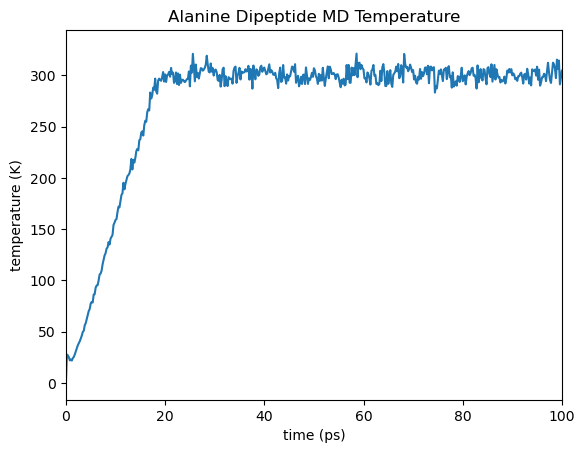

In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
temp = np.loadtxt('ANALYSIS/summary.TEMP')
plt.plot(temp[:,0], temp[:,1])
plt.title('Alanine Dipeptide MD Temperature')
plt.ylabel('temperature (K)')
plt.xlabel('time (ps)')
plt.xlim(0, 100);

Note that the system energy changes drastically at the start (due to the gradual heating) before stablizing. 

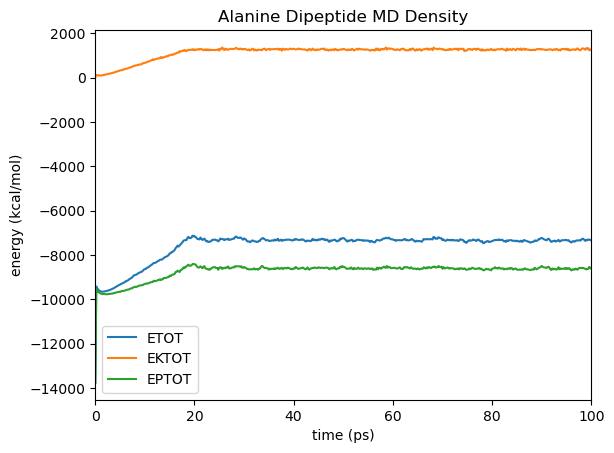

In [96]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
etot = np.loadtxt('ANALYSIS/summary.ETOT')
ektot = np.loadtxt('ANALYSIS/summary.EKTOT')
eptot = np.loadtxt('ANALYSIS/summary.EPTOT')

for y, label in zip([etot[:,1], ektot[:,1], eptot[:,1]],['ETOT', 'EKTOT', 'EPTOT']) :
    plt.plot(etot[:,0], y, label=label)
plt.title('Alanine Dipeptide MD Density')
plt.ylabel('energy (kcal/mol)')
plt.xlabel('time (ps)')
plt.legend()
plt.xlim(0, 100);

Next, we will use `MDTraj` to analyze the RMSD.

The root mean squared deviation (RMSD) value is a measurement of how similar a structure's internal atomic coordinates are relative to some reference molecule coordinates. For this example, we will measure how the internal atomic coordinates change relative to the minimized structure. Specifically, we will analyze the alanine atoms (residue 2).

To do this analysis, we will use mdtraj, a fairly comprehensive analysis program for processing MD trajectories. This program runs python functions that choose what trajectories to load, what analysis to run, and what processed trajectories or structure to save.

In [122]:
import mdtraj
a = mdtraj.load(['sample_files/02_Heat.nc'], top='diala.parm7') # Load the first
ref = mdtraj.load('sample_files/01_Min.ncrst', top='diala.parm7')
a = a.image_molecules()  # Make sure our system is imaged, for solving cases where parts of our protein might be poking off the side of our periodic box, reappearing on the other side 
diala_indices = a.topology.select('resid 2') # Looking at Residue 2, which is ALA
a = a.superpose(ref, atom_indices=diala_indices)  # aligning to first frame
rmsd = mdtraj.rmsd(a, ref, atom_indices=diala_indices)*10 # to get everything in Angstrom

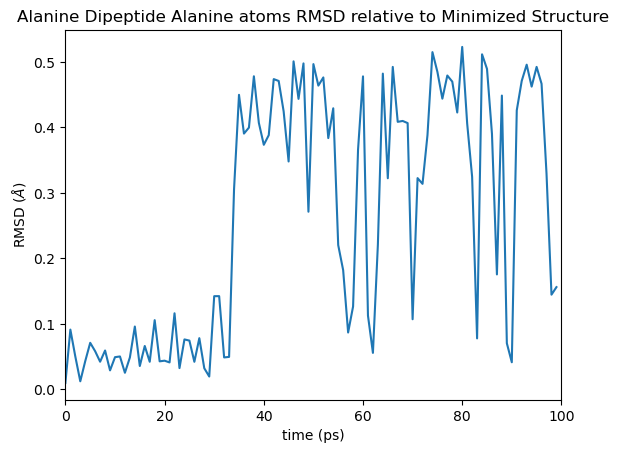

In [125]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.plot(rmsd)
plt.title('Alanine Dipeptide Alanine atoms RMSD relative to Minimized Structure')
plt.ylabel(r'RMSD ($\AA$)')
plt.xlabel('time (ps)')
plt.xlim(0, 100);

In this example, there is no significant conformational change in the positions of the alanine dipeptide atoms relative to the starting structure. 

## Conclusion

Congratulations. You've now run your first complete MD simulation and successfully analyzed the results. This is a fairly simple example of the workflow for setting up, running, and analyzing your own MD simulation. If you want to learn more you are encouraged to complete the additional tutorials on the AMBER website.